# Importing the Libraries

In [1]:
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras import regularizers, optimizers
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import layers
from keras.metrics import categorical_crossentropy
from tensorflow.keras import Model, Input
from tensorflow.keras import utils
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, accuracy_score, ConfusionMatrixDisplay

# Loading and Preprocessing the Data


In [2]:
%cp /content/drive/MyDrive/Dataset/ -r /content/

In [3]:
train = tf.keras.utils.image_dataset_from_directory(
    '/content/Dataset/Train',
    labels='inferred' ,
    label_mode = 'categorical',
    color_mode="rgb",
    image_size=(64, 64),
    shuffle=True,
    batch_size=128,
    seed= 10,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
)

val = tf.keras.utils.image_dataset_from_directory(
    '/content/Dataset/Val',
    labels='inferred' ,
    label_mode = 'categorical',
    color_mode="rgb",
    image_size=(64, 64),
    shuffle=False,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
)

test = tf.keras.utils.image_dataset_from_directory(
    '/content/Dataset/Test',
    labels='inferred' ,
    label_mode = 'categorical',
    color_mode="rgb",
    image_size=(64, 64),
    shuffle=False,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
)

Found 5908 files belonging to 4 classes.
Found 855 files belonging to 4 classes.
Found 825 files belonging to 4 classes.


In [4]:
aug_2 = layers.Rescaling(1./255)

train = train.map(lambda x, y: (aug_2(x), y))
val = val.map(lambda x, y: (aug_2(x), y)) 
test = test.map(lambda x, y: (aug_2(x), y)) 

In [5]:
y_test = np.concatenate([y for x, y in val], axis=0)
x_test = np.concatenate([x for x, y in val], axis=0)

# DenseNet

In [10]:
Network = tf.keras.applications.DenseNet121(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(64,64,3),
    pooling='avg',
)
Network.summary()

Model: "densenet121"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 zero_padding2d_2 (ZeroPadding2  (None, 70, 70, 3)   0           ['input_2[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1/conv (Conv2D)            (None, 32, 32, 64)   9408        ['zero_padding2d_2[0][0]']       
                                                                                                  
 conv1/bn (BatchNormalization)  (None, 32, 32, 64)   256         ['conv1/conv[0][0]']   

In [11]:
for layer in Network.layers: 
  layer.trainable = False
last_layer = Network.get_layer('avg_pool')
last_output = last_layer.output
x = tf.keras.layers.Dense(4, activation='softmax')(last_output)

In [12]:
model = Model(inputs=Network.input, outputs=x) 
model.compile(keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
history = model.fit(train, validation_data=val, epochs=20, verbose=1)

Epoch 1/20
47/47 [==============================] - 10s 82ms/step - loss: 1.8151 - accuracy: 0.3932 - val_loss: 1.4584 - val_accuracy: 0.4456
Epoch 2/20
47/47 [==============================] - 2s 42ms/step - loss: 1.2633 - accuracy: 0.5068 - val_loss: 1.1602 - val_accuracy: 0.5509
Epoch 3/20
47/47 [==============================] - 2s 42ms/step - loss: 0.9886 - accuracy: 0.6215 - val_loss: 0.9635 - val_accuracy: 0.6187
Epoch 4/20
47/47 [==============================] - 2s 43ms/step - loss: 0.8062 - accuracy: 0.7075 - val_loss: 0.8177 - val_accuracy: 0.6749
Epoch 5/20
47/47 [==============================] - 2s 42ms/step - loss: 0.6776 - accuracy: 0.7595 - val_loss: 0.7102 - val_accuracy: 0.7181
Epoch 6/20
47/47 [==============================] - 2s 43ms/step - loss: 0.5828 - accuracy: 0.7989 - val_loss: 0.6281 - val_accuracy: 0.7579
Epoch 7/20
47/47 [==============================] - 2s 43ms/step - loss: 0.5103 - accuracy: 0.8309 - val_loss: 0.5638 - val_accuracy: 0.8035
Epoch 8/20
4

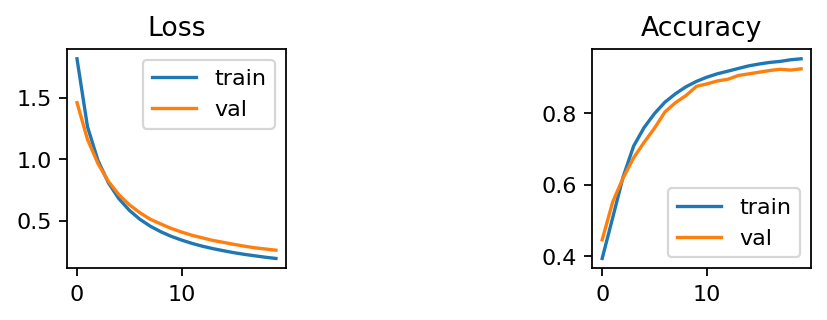

In [14]:
plt.figure( dpi=160)

plt.subplot(231)
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()

plt.subplot(233)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.legend()
plt.show()

In [15]:
y_hat = model.predict(x_test)

27/27 [==============================] - 2s 15ms/step


In [16]:
y_hat[y_hat>=0.5] = 1
y_hat[y_hat<0.5] = 0


For Test Set
F1 score:  0.9208804283164783
Accuracy:  0.9052631578947369
Precision:  0.937046004842615
Recall:  0.9052631578947369
Confusion Matrix: 



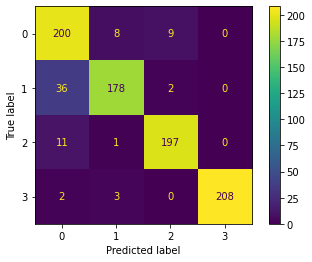

In [17]:
print('\nFor Test Set')
f1 = f1_score(y_test, y_hat, average='micro')
print('F1 score: ' , f1)

accuracy = accuracy_score(y_test, y_hat)
print('Accuracy: ' , accuracy)

precision = precision_score(y_test, y_hat, average='micro')
print('Precision: ' , precision)

recall = recall_score(y_test, y_hat, average='micro')
print('Recall: ' , recall)

matrix = ConfusionMatrixDisplay(confusion_matrix(y_test.argmax(axis=1), y_hat.argmax(axis=1)))
print('Confusion Matrix: \n')
matrix.plot()
plt.show()

# ResNet

In [18]:
Network = tf.keras.applications.ResNet50(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(64,64,3),
    pooling='avg',
)
Network.summary()

94765736/94765736 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 70, 70, 3)    0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 32, 32, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 32, 32, 64)   256         ['conv1_conv[0][0]']             
                          

In [19]:
for layer in Network.layers: 
  layer.trainable = False
last_layer = Network.get_layer('avg_pool')
last_output = last_layer.output
x = tf.keras.layers.Dense(4, activation='softmax')(last_output)

In [20]:
model = Model(inputs=Network.input, outputs=x) 
model.compile(keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [21]:
history = model.fit(train, validation_data=val, epochs=20, verbose=1)

Epoch 1/20
47/47 [==============================] - 6s 56ms/step - loss: 1.3935 - accuracy: 0.2920 - val_loss: 1.3797 - val_accuracy: 0.3743
Epoch 2/20
47/47 [==============================] - 2s 36ms/step - loss: 1.3760 - accuracy: 0.3961 - val_loss: 1.3738 - val_accuracy: 0.4468
Epoch 3/20
47/47 [==============================] - 2s 36ms/step - loss: 1.3724 - accuracy: 0.4377 - val_loss: 1.3709 - val_accuracy: 0.4468
Epoch 4/20
47/47 [==============================] - 2s 35ms/step - loss: 1.3693 - accuracy: 0.4435 - val_loss: 1.3680 - val_accuracy: 0.4667
Epoch 5/20
47/47 [==============================] - 2s 36ms/step - loss: 1.3663 - accuracy: 0.5303 - val_loss: 1.3650 - val_accuracy: 0.5228
Epoch 6/20
47/47 [==============================] - 2s 36ms/step - loss: 1.3631 - accuracy: 0.5625 - val_loss: 1.3622 - val_accuracy: 0.5789
Epoch 7/20
47/47 [==============================] - 2s 36ms/step - loss: 1.3602 - accuracy: 0.5829 - val_loss: 1.3592 - val_accuracy: 0.5626
Epoch 8/20
47

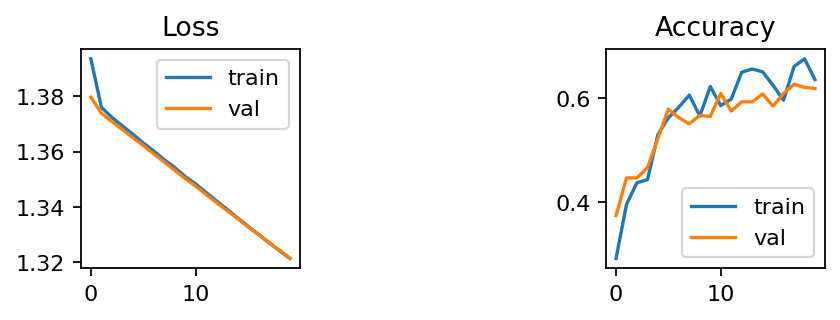

In [22]:
plt.figure( dpi=160)

plt.subplot(231)
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()

plt.subplot(233)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.legend()

plt.show()

In [26]:
y_hat = model.predict(x_test)

27/27 [==============================] - 0s 8ms/step


In [24]:
y_hat[y_hat>=0.5] = 1
y_hat[y_hat<0.5] = 0


For Test Set
F1 score:  0.0
Accuracy:  0.0
Precision:  0.0
Recall:  0.0
Confusion Matrix: 



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


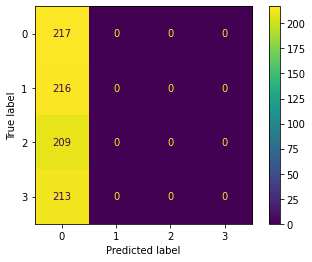

In [25]:
print('\nFor Test Set')
f1 = f1_score(y_test, y_hat, average='micro')
print('F1 score: ' , f1)

accuracy = accuracy_score(y_test, y_hat)
print('Accuracy: ' , accuracy)

precision = precision_score(y_test, y_hat, average='micro')
print('Precision: ' , precision)

recall = recall_score(y_test, y_hat, average='micro')
print('Recall: ' , recall)

matrix = ConfusionMatrixDisplay(confusion_matrix(y_test.argmax(axis=1), y_hat.argmax(axis=1)))
print('Confusion Matrix: \n')
matrix.plot()
plt.show()

This result is because of high loss

# VGG16

In [28]:
Network = tf.keras.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(64,64,3),
    pooling='avg',
)
Network.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                              

In [29]:
for layer in Network.layers: 
  layer.trainable = False
last_layer = Network.get_layer('global_average_pooling2d')
last_output = last_layer.output
x = tf.keras.layers.Dense(4, activation='softmax')(last_output)

In [30]:
model = Model(inputs=Network.input, outputs=x) 
model.compile(keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [31]:
history = model.fit(train, validation_data=val, epochs=20, verbose=1)

Epoch 1/20
47/47 [==============================] - 3s 35ms/step - loss: 1.5332 - accuracy: 0.2503 - val_loss: 1.4450 - val_accuracy: 0.2491
Epoch 2/20
47/47 [==============================] - 2s 32ms/step - loss: 1.4062 - accuracy: 0.2586 - val_loss: 1.3551 - val_accuracy: 0.2608
Epoch 3/20
47/47 [==============================] - 2s 32ms/step - loss: 1.3452 - accuracy: 0.2874 - val_loss: 1.3087 - val_accuracy: 0.3427
Epoch 4/20
47/47 [==============================] - 2s 32ms/step - loss: 1.3105 - accuracy: 0.4094 - val_loss: 1.2786 - val_accuracy: 0.5532
Epoch 5/20
47/47 [==============================] - 2s 35ms/step - loss: 1.2841 - accuracy: 0.5922 - val_loss: 1.2522 - val_accuracy: 0.7287
Epoch 6/20
47/47 [==============================] - 2s 32ms/step - loss: 1.2599 - accuracy: 0.7167 - val_loss: 1.2280 - val_accuracy: 0.7883
Epoch 7/20
47/47 [==============================] - 2s 31ms/step - loss: 1.2367 - accuracy: 0.7664 - val_loss: 1.2046 - val_accuracy: 0.8140
Epoch 8/20
47

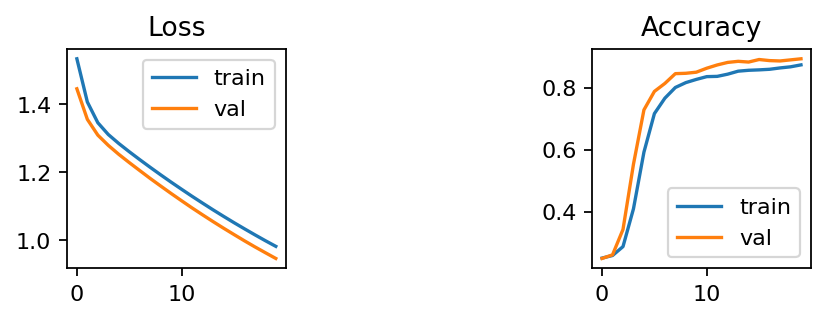

In [32]:
plt.figure( dpi=160)

plt.subplot(231)
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()

plt.subplot(233)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.legend()
plt.show()

In [33]:
y_hat = model.predict(x_test)

27/27 [==============================] - 0s 4ms/step


In [34]:
y_hat[y_hat>=0.5] = 1
y_hat[y_hat<0.5] = 0


For Test Set
F1 score:  0.24435318275154005
Accuracy:  0.1391812865497076
Precision:  1.0
Recall:  0.1391812865497076
Confusion Matrix: 



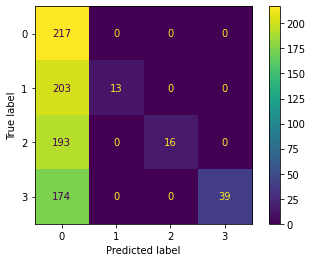

In [35]:
print('\nFor Test Set')
f1 = f1_score(y_test, y_hat, average='micro')
print('F1 score: ' , f1)

accuracy = accuracy_score(y_test, y_hat)
print('Accuracy: ' , accuracy)

precision = precision_score(y_test, y_hat, average='micro')
print('Precision: ' , precision)

recall = recall_score(y_test, y_hat, average='micro')
print('Recall: ' , recall)

matrix = ConfusionMatrixDisplay(confusion_matrix(y_test.argmax(axis=1), y_hat.argmax(axis=1)))
print('Confusion Matrix: \n')
matrix.plot()
plt.show()